In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from lib_processing import data_processing as processing
import nltk
from transformers import AutoTokenizer
import torch
from tqdm import tqdm
import re
import spacy

nltk.download('stopwords')
from nltk.corpus import stopwords
import multiprocessing
import plotly.io as pio
pio.renderers.default = "notebook"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
corpus_df = processing.get_data()

Retrieving data from ParlaMint-AT...
./data/parlamint_at_extracted\README-AT.md
./data/parlamint_at_extracted\ParlaMint-AT.TEI\00README.txt
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-AT-listOrg.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-AT-listPerson.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-AT.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-taxonomy-CHES.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-taxonomy-parla.legislature.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-taxonomy-politicalOrientation.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-taxonomy-speaker_types.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\ParlaMint-taxonomy-subcorpus.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\1996\ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001.xml
./data/parlamint_at_extracted\ParlaMint-AT.TEI\1996\ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00002.xml
./data/parlamint_at_extracted\P

In [3]:
corpus_df.head()

,ID,text,Text_ID,Title,Date,Body,Term,Session,Meeting,Sitting,...,Speaker_MP,Speaker_minister,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth
0,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,Bitte Platz zu nehmen. – Ich bitte auch die Ph...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,Sitting 1,...,MP,notMinister,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938
1,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,Der Herr Bundespräsident hat mit Entschließung...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,Sitting 1,...,MP,notMinister,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938
2,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,Wir gehen in die Tagesordnung ein und gelangen...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,Sitting 1,...,MP,notMinister,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938
3,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,Sie werden geloben unverbrüchliche Treue der R...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,Sitting 1,...,MP,notMinister,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_01153,"Parfuss, Ludmilla",F,1942
4,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,Danke. Die Angelobung ist damit beendet. Meine...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,Sitting 1,...,MP,notMinister,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938


converting date and extracting month and year to be albe to filter and generate a smaller POC data set.

In [4]:
df_sent = pd.read_csv("data/corpus_normalised_tokens.csv")
# Convert to datetime
df_sent['Date'] = pd.to_datetime(df_sent['Date'])

# Extract year and month
df_sent['year'] = df_sent['Date'].dt.year
df_sent['month'] = df_sent['Date'].dt.month
df_sent.head()

C:\Users\lukas\AppData\Local\Temp\ipykernel_21904\3078247261.py:1: DtypeWarning:

Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.



,Unnamed: 0,ID,text,Text_ID,Title,Date,Body,Term,Session,Meeting,...,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth,year,month
0,0,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,"platz zu. ich auch die photographen, ihre täti...",ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,...,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938,1996,1
1,1,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,der hat mit entschließung vom 9. jänner gemäß ...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,...,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938,1996,1
2,2,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,wir in die tagesordnung ein und gelangen zum 1...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,...,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938,1996,1
3,3,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,sie geloben unverbrüchliche treue der republik...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,...,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_01153,"Parfuss, Ludmilla",F,1942,1996,1
4,4,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,. die angelobung ist damit beendet.! sie sich ...,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,...,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00334,"Fischer, Heinz",M,1938,1996,1


In [5]:
df_sent["text"].iloc[0]

'platz zu. ich auch die photographen, ihre tätigkeit einzustellen. die erste und konstituierende sitzung des nationalrates der xx. gesetzgebungsperiode des nationalrates eröffnen. ich begrüße hiezu alle mitglieder des hohen hauses herzlich, und zwar sowohl jene, die neuerlich in den nationalrat gewählt wurden, als auch jene, die erstmals an einer sitzung des nationalrates teil. mit respekt begrüße ich den herrn bundespräsidenten, der bei dieser sitzung anwesend ist. auch jene bürgerinnen und bürger begrüßen, die als zuseher die liveübertragung dieser sitzung im fern verfolgen. einberufung der ordentlichen tagung 1996'

In [6]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from germansentiment import SentimentModel

def extract_compound_sentiment_from_speech(speech, model,console_out):
    all_probs = []
    sentences = sent_tokenize(speech, language='german')
    print(len(sentences))
    sentiment_weight = {'positive': 1, 'negative': -1, 'neutral': 0}
    compound_scores = []

    for sentence in sentences:
        _, result = model.predict_sentiment([sentence], output_probabilities=True)
        prob_pairs = result[0]
        prob_dict = {label: prob for label, prob in prob_pairs}
        all_probs.append(prob_dict)

        # Sentence-level compound score
        score = sum(prob_dict[label] * sentiment_weight[label] for label in sentiment_weight)
        compound_scores.append(score)

    # Overall compound sentiment and variance
    compound_score = np.mean(compound_scores)
    compound_variance = np.var(compound_scores)

    if console_out == True:
        print("Compound sentiment score:", round(compound_score, 4))
        print("Compound sentiment variance:", round(compound_variance, 4))

    return compound_score, compound_variance,



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:

model = SentimentModel()

compound_score, compound_variance = extract_compound_sentiment_from_speech(df_sent["text"].iloc[0], model,console_out=True)
df_sent["text"].iloc[0]

8
Compound sentiment score: -0.1116
Compound sentiment variance: 0.0879


'platz zu. ich auch die photographen, ihre tätigkeit einzustellen. die erste und konstituierende sitzung des nationalrates der xx. gesetzgebungsperiode des nationalrates eröffnen. ich begrüße hiezu alle mitglieder des hohen hauses herzlich, und zwar sowohl jene, die neuerlich in den nationalrat gewählt wurden, als auch jene, die erstmals an einer sitzung des nationalrates teil. mit respekt begrüße ich den herrn bundespräsidenten, der bei dieser sitzung anwesend ist. auch jene bürgerinnen und bürger begrüßen, die als zuseher die liveübertragung dieser sitzung im fern verfolgen. einberufung der ordentlichen tagung 1996'

In [26]:
df_speeches = df_sent[["year","text"]].copy()
df_speeches = df_speeches[df_speeches["year"] >= 2019]
df_speeches = df_speeches[["text"]]

In [9]:
df_speeches.tail()

,text
231752,abgeordneter sieber..
231753,! frau minister! geschätzte kolleginnen und ko...
231754,zu wort ist dazu niemand gemeldet. die debatte...
231755,wir zu den verlegten abstimmungen. wir abstimm...
231756,"bekannt, dass in der heutigen sitzung die selb..."


In [27]:
texts = df_speeches['text']

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm

# Load tokenizer and model
model_name = "oliverguhr/german-sentiment-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("Model is on:", next(model.parameters()).device)

texts = df_speeches['text']

batch_size = 32
compound_scores = []
compound_variances = []
df_sentiment_result = pd.DataFrame()

sentiment_weight = {'positive': 1, 'negative': -1, 'neutral': 0}
labels = ['positive','negative', 'neutral', ]  # label order in model output

def sentence_level_scores(sentence):
    # Tokenize sentence, move to device
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    prob_dict = dict(zip(labels, probs))
    # Compound score for this sentence
    score = sum(prob_dict[label] * sentiment_weight[label] for label in sentiment_weight)
    return prob_dict, score

from nltk.tokenize import sent_tokenize

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch = texts[i:i+batch_size]
    for speech in batch:
        sentences = sent_tokenize(speech, language='german')
        all_probs = []
        compound_scores_sentences = []

        for sent in sentences:
            prob_dict, score = sentence_level_scores(sent)
            all_probs.append(prob_dict)
            compound_scores_sentences.append(score)

        # Aggregate over sentences
        avg_probs = {label: np.mean([p[label] for p in all_probs]) for label in labels}
        var_probs = {label: np.var([p[label] for p in all_probs]) for label in labels}

        compound_score = np.mean(compound_scores_sentences)
        compound_variance = np.var(compound_scores_sentences)

        compound_scores.append(compound_score)
        compound_variances.append(compound_variance)

# Add to DataFrame
df_sentiment_result['compound_score'] = compound_scores
df_sentiment_result['compound_variance'] = compound_variances
df_sentiment_result.to_csv("data/extractted_sentiment_2019_2022.csv")

Model is on: cuda:0


Processing batches:   1%|          | 11/974 [00:55<1:20:25,  5.01s/it]


KeyboardInterrupt: 

In [12]:
df_sentiment_result.head()

,compound_score,compound_variance
0,-0.014922,0.000497
1,0.045437,0.035684
2,-0.013735,0.138994
3,-0.002557,0.000005
4,-0.054676,0.042504


<Axes: >

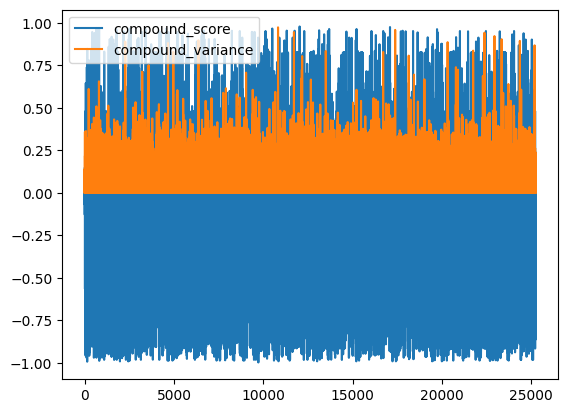

In [13]:
df_sentiment_result.plot()

In [15]:
df_sent = pd.read_csv("data/sentiment_base.csv")
# Convert to datetime
df_sent['Date'] = pd.to_datetime(df_sent['Date'])

# Extract year and month
df_sent['year'] = df_sent['Date'].dt.year
df_sent['month'] = df_sent['Date'].dt.month

df2020_22 = df_sent[df_sent["year"] >= 2020]
df2020_22.reset_index(inplace=True)
df_sentiment_result = pd.read_csv("data/extractted_sentiment.csv")

new_df = pd.concat([df2020_22,df_sentiment_result], axis=1)
new_df.drop(columns=["Unnamed: 0"],inplace=True)
new_df.to_csv("data/2020_22_sentiment_base.csv",index=True)
new_df.head()


C:\Users\lukas\AppData\Local\Temp\ipykernel_21904\3000819271.py:1: DtypeWarning:

Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.



,index,ID,text,Text_ID,Title,Date,Body,Term,Session,Meeting,...,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth,year,month,compound_score,compound_variance
0,206521,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008...,Meine sehr geehrten Damen und Herren! Ich darf...,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008,"Sitting Number 8, Legislative period XXVII, Fr...",2020-01-10,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2020,1,-0.014922,0.000497
1,206522,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008...,"Ich darf bekannt geben, dass von der Bundeswah...",ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008,"Sitting Number 8, Legislative period XXVII, Fr...",2020-01-10,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2020,1,0.045437,0.035684
2,206523,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008...,„Sie werden geloben unverbrüchliche Treue der ...,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008,"Sitting Number 8, Legislative period XXVII, Fr...",2020-01-10,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_08209,"Gahr, Hermann",M,1960,2020,1,-0.013735,0.138994
3,206524,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008...,Ich darf die neuen Abgeordneten in unserer Mit...,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008,"Sitting Number 8, Legislative period XXVII, Fr...",2020-01-10,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2020,1,-0.002557,0.000005
4,206525,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008...,Vom Bundeskanzler ist folgendes Schreiben eing...,ParlaMint-AT_2020-01-10-027-XXVII-NRSITZ-00008,"Sitting Number 8, Legislative period XXVII, Fr...",2020-01-10,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2020,1,-0.054676,0.042504


In [25]:
pd.read_csv("data/2022_sentiment_base.csv").head()

,index,ID,text,Text_ID,Title,Date,Body,Term,Session,Meeting,...,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth,year,month,compound_score,compound_variance
0,225830,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139...,Meine Damen und Herren Abgeordnete! Ich darf S...,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139,"Sitting Number 139, Legislative period XXVII, ...",2022-01-20,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2022,1,-6.993264e-02,1.456473e-02
1,225831,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139...,Am Beginn der Sitzung möchte ich des ehemalige...,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139,"Sitting Number 139, Legislative period XXVII, ...",2022-01-20,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2022,1,-5.636453e-04,7.997456e-07
2,225832,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139...,"In der Präsidialkonferenz wurde vereinbart, da...",ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139,"Sitting Number 139, Legislative period XXVII, ...",2022-01-20,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2022,1,1.077551e-01,8.355017e-02
3,225833,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139...,Von der Bundeswahlbehörde ist die Mitteilung e...,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139,"Sitting Number 139, Legislative period XXVII, ...",2022-01-20,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_88386,"Sobotka, Wolfgang",M,1956,2022,1,-9.026225e-04,3.190024e-06
4,225834,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139...,„Sie werden geloben unverbrüchliche Treue der ...,ParlaMint-AT_2022-01-20-027-XXVII-NRSITZ-00139,"Sitting Number 139, Legislative period XXVII, ...",2022-01-20,Lower house,Legislative period XXVII,-,-,...,Coalition,Centre-right to right,PAD_83059,"Steinacker, Michaela",F,1962,2022,1,-6.408336e-07,0.000000e+00


In [85]:
import plotly.express as px
new_df = new_df[new_df["Speaker_role"]!="Chairperson"]
fig = px.line(new_df, x="datetime_ordered", y="compound_score", title='Life expectancy in Canada',color='Speaker_party')
fig.show()

In [86]:
df_day= new_df[new_df["Date"] == "2022-02-24"]
fig = px.bar(df_day, x="datetime_ordered", y="compound_score", title='Life expectancy in Canada',color='Speaker_party')
fig.show()

# Setting up  the df for streamlit

In [25]:
df_sentimet = pd.read_csv("data/2020_22_sentiment_base.csv")
df_topics = pd.read_csv("data/corpus_topics_filtered.csv")
df_sentimet['Text_ID'] = df_sentimet['Text_ID'].astype(str)
df_topics['Text_ID'] = df_topics['Text_ID'].astype(str)
df_result = df_sentimet.merge(df_topics, on="Text_ID",how="left")


In [29]:
df_result.isna().sum()

Unnamed: 0            0
index                 0
ID                    0
text                  0
Text_ID               0
Title                 0
Date                  0
Body                  0
Term                  0
Session               0
Meeting               0
Sitting               0
Agenda                0
Subcorpus             0
Lang                  0
Speaker_role          0
Speaker_MP            0
Speaker_minister      0
Speaker_party         0
Speaker_party_name    0
Party_status          0
Party_orientation     0
Speaker_ID            0
Speaker_name          0
Speaker_gender        0
Speaker_birth         0
year                  0
month                 0
compound_score        0
compound_variance     0
Topic 1               0
Confidence 1          0
Topic 2               0
Confidence 2          0
Topic 3               0
Confidence 3          0
dtype: int64

In [31]:
df_result.to_csv("data/2020_22_Sentiment_base_with_topics.csv")

In [33]:
df_result.shape

(10820219, 36)